# Set-up

## Packages

In [ ]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 

from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import LabelModel, MajorityLabelVoter
from snorkel.labeling import filter_unlabeled_dataframe
 
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from scipy.stats import kendalltau, spearmanr

## Load data

In [ ]:
#Load the train set without company accounts (27424 accounts)
train_df = pd.read_csv('output/train_set_no_company.csv').fillna(" ")
#Load the test set
test_df = pd.read_csv('output/test_set.csv').fillna(" ")
#Load the target labels (hand labeled)
test_target = pd.read_csv('output/test_set_labels.csv', sep = ',')

#Remove the company accounts from the test set
company_idx = test_target[test_target['company_label_majority'] == True].index.to_list()  
test_target = test_target[~test_target.index.isin(company_idx)]
test_df = test_df[~test_df.index.isin(company_idx)]

In [ ]:
def removehyperlink(row):
  #As preprocessing, remove any hyperlinks from the user profile description
  tt = TweetTokenizer()
  tokenized_row = tt.tokenize(row)
  tokenized_row = [word for word in tokenized_row if 'http' not in word]
  return ' '.join(tokenized_row)

train_df['description'] = train_df['description'].apply(lambda row: removehyperlink(row))
test_df['description'] = test_df['description'].apply(lambda row: removehyperlink(row))

In [ ]:
#Create three test sets : one for each target variable
target_gender = test_target[test_target['gender_label_majority'] != 'Unknown'].gender_label_majority
gender_test_df = test_df[test_df.index.isin(target_gender.index)]

target_age = test_target[test_target['age_label_majority'] != 'Unknown'].age_label_majority
age_test_df = test_df[test_df.index.isin(target_age.index)]

target_location = test_target[test_target['location_label_majority'] != 'Unknown'].location_label_majority
location_test_df = test_df[test_df.index.isin(target_location.index)]

# Data labelling

## Gender labeling
Gender labeling can be done based on user names, keyword searches and the predictions of third-party models.

In [ ]:
FEMALE = 0
MALE = 1
ABSTAIN = -1

In [ ]:
#Code to write snorkel keyword search labeling function
def keyword_lookup(x,keywords, label):
  if any(word in x['description'].lower().split(' ') for word in keywords):
    return label
  return ABSTAIN

def make_keyword_lf(keywords, label = ABSTAIN):
  return LabelingFunction(
      name = f"keyword_{label}",
      f = keyword_lookup,
      resources = dict(keywords = keywords, label = label),
  )

### Based on user names

In [ ]:
#Isolate the first name of users, set it to lower case.
train_df['first_name'] = train_df['name'].apply(lambda row: row.split(' ')[0].lower())
gender_test_df['first_name'] = gender_test_df['name'].apply(lambda row: row.split(' ')[0].lower())

In [ ]:
#Load first names gender dictionary
names = pd.read_csv("Data_Labelling/Gender/names.csv")

In [ ]:
female_names = [n.lower() for n in names["Vrouw"] if type(n) == str]
male_names = [n.lower() for n in names["Man"]  if type(n) == str]

In [ ]:
female_names_set = set(female_names)
male_names_set = set(male_names)
bigender_names_set = female_names_set.intersection(male_names_set)

In [ ]:
#Create Snorkel labelling functions
@labeling_function()
def male_first_name(x):
  return MALE if x['first_name'] in male_names and not x['first_name'] in bigender_names_set else ABSTAIN

@labeling_function()
def female_first_name(x):
  return FEMALE if x['first_name'] in female_names and not x['first_name'] in bigender_names_set else ABSTAIN

### Based on description

In [ ]:
#Load gender keywords
gender_keywords = pd.read_csv("Data_Labelling/Gender/GenderKeywords.csv")
male = gender_keywords['Male'].dropna().to_list() 
female = gender_keywords['Female'].dropna().to_list() 

In [ ]:
#make gender keyword LFs 
male_keywords = make_keyword_lf(keywords = male, label = MALE)
female_keywords = make_keyword_lf(keywords = female, label = FEMALE)

### Based on 3rd party models (DeepFace & CLIP)


In [ ]:
deepface = pd.read_csv('Data_Labelling/Gender/deepface.csv')
CLIP = pd.read_csv('Data_Labelling/Gender/CLIP.csv')

In [ ]:
#Create Snorkel labelling functions
@labeling_function()
def male_deepface(x,deepface = deepface):
  pred = deepface.loc[deepface['user_id'] == x['user_id'],'deepface_gender'].values[0]
  return MALE if pred == 1 else ABSTAIN

@labeling_function()
def female_deepface(x,deepface = deepface):
  pred = deepface.loc[deepface['user_id'] == x['user_id'],'deepface_gender'].values[0]
  return FEMALE if pred == 0 else ABSTAIN  

@labeling_function()
def male_CLIP(x,CLIP = CLIP):
  pred = CLIP.loc[CLIP['user_id'] == x['user_id'],'CLIP_gender'].values[0]
  return MALE if pred == 1 else ABSTAIN

@labeling_function()
def female_CLIP(x,CLIP = CLIP):
  pred = CLIP.loc[CLIP['user_id'] == x['user_id'],'CLIP_gender'].values[0]
  return FEMALE if pred == 0 else ABSTAIN 


### All labeling functions: predict labels using snorkel LFs for Gender

In [ ]:
#Build the label matrix
lfs_gender = [male_first_name, female_first_name, 
              male_keywords, female_keywords,
              male_deepface, female_deepface,
              male_CLIP, female_CLIP] 
gender_applier = PandasLFApplier(lfs=lfs_gender)
L_gender = gender_applier.apply(df=train_df)
L_gender_test = gender_applier.apply(df = gender_test_df)

100%|██████████| 489/489 [00:01<00:00, 465.40it/s]


In [ ]:
#Summary statistics for the LFs applied on the train set
LFAnalysis(L=L_gender, lfs=lfs_gender).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
male_first_name,0,[1],0.370223,0.294487,0.008897
female_first_name,1,[0],0.158438,0.125000,0.034094
keyword_1,2,[1],0.048716,0.044632,0.002917
keyword_0,3,[0],0.028333,0.025088,0.008241
male_deepface,4,[1],0.304368,0.298315,0.042590
female_deepface,5,[0],0.086129,0.084889,0.007949
male_CLIP,6,[1],0.467364,0.381308,0.018451
female_CLIP,7,[0],0.203216,0.160407,0.040257



## Age labeling


Age labelling is the most difficult to do of our 3 target variables. It can be done based on the description or the optional birthday field. The latter one is not available to us, therefore we based everything on the description. We used keyword searches and regular expressions to write labeling functions.

In [ ]:
MINOR = 1
TWENTIES = 2
THIRTIES = 3
FOURTIESABOVE = 4
ABSTAIN = -1

### Based on description

#### Keyword searches

In [ ]:
#Load age keywords
age_keywords = pd.read_csv("Data_Labelling/Age/AgeKeywords.csv")
fourtiesabove = age_keywords['40+'].dropna().to_list() 
thirties = age_keywords['30-39'].dropna().to_list() 
twenties = age_keywords['19-29'].dropna().to_list() 
minor = age_keywords['-18'].dropna().to_list() 

In [ ]:
#make keyword LFs 
fourtiesabove_keywords = make_keyword_lf(keywords = fourtiesabove, label = FOURTIESABOVE)
thirties_keywords = make_keyword_lf(keywords = thirties, label = THIRTIES)
twenties_keywords = make_keyword_lf(keywords = twenties, label = TWENTIES)
minor_keywords = make_keyword_lf(keywords = minor, label = MINOR)

#### Regular expressions

In [ ]:
#LF for minor 
#included ages 13-18: 1[3-8]
@labeling_function()
def regex_minor_jaar(row):
  return MINOR if re.search(r"([^0-9]1[3-8]\s*(y\/?o?)\s)|(\b1[3-8]\s*-?(i?)(jaar|jaren|years?|lentes|jarige?|años))", row['description']) else ABSTAIN

@labeling_function()
def regex_minor_begin(row):
  return MINOR if re.search(r"(^\s*1[3-8]\s*[^0-9\./])|(^°?\s*200[4-9]\s*)|(^°?\s*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?200[4-9]\s*)", row['description']) else ABSTAIN

@labeling_function()
def regex_minor_only(row):
  return MINOR if re.search(r"(^\s*1[3-8]\s*$)|(^\s*200[4-9]\s*$)", row['description']) else ABSTAIN

@labeling_function()
def regex_minor_delimiterage(row):
  return MINOR if re.search(r"([^0-9]\|\s?1[3-8]\s?\|[^0-9])|([^0-9]\.\s?1[3-8]\s?\.[^0-9])|([^0-9],\s?1[3-8]\s?,[^0-9])|([^0-9]-\s?1[3-8]\s?-[^0-9])|([^0-9]•\s?1[3-8]\s?•[^0-9])", row['description']) else ABSTAIN

@labeling_function()
def regex_minor_delimiterbd(row):
  return MINOR if re.search(r"(\|\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?200[4-9]\s?\|)|(\.\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?200[4-9]\s?\.)|(,\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?200[4-9]\s?,)|(-\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?200[4-9]\s?-)|(•\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?200[4-9]\s?•)", row['description']) else ABSTAIN

@labeling_function()
def regex_minor_born(row):
  return MINOR if re.search(r"(\b(?i)(born(\sin)?|anno|est.?|circa|ca\.?|sedert|°)\s*'?0[4-9]\s)|(^\s*(?i)(since|sinds)\s*'?0[4-9]\s)", row['description']) else ABSTAIN

@labeling_function()
def regex_minor_bornfull(row):
  return MINOR if re.search(r"(\b(?i)(born(\son)?|anno|est.?|circa|ca\.?|sedert|since|°|birthday)\s*\W*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?200[4-9])|(^\s*(?i)(since|sinds)\s*\W*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?200[4-9])", row['description']) else ABSTAIN


In [ ]:
#LF for twenties 
#included ages 19-29
@labeling_function()
def regex_twenties_jaar(row):
  return TWENTIES if re.search(r"([^0-9](19|2[0-9])\s*(y\/?o?)\s)|(\b(19|2[0-9])\s*-?(i?)(jaar|jaren|years?|lentes|jarige?|años))", row['description']) else ABSTAIN

@labeling_function()
def regex_twenties_begin(row):
  return TWENTIES if re.search(r"(^\s*(19|2[0-9])\s*[^0-9])|(^°?\s*(200[0-3]|199[3-9])\s*)|(^°?\s*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(200[0-3]|199[3-9])\s*)", row['description']) else ABSTAIN

@labeling_function()
def regex_twenties_only(row):
  return TWENTIES if re.search(r"(^\s*(19|2[0-9])\s*$)|(^\s*(200[0-3]|199[3-9])\s*$)", row['description']) else ABSTAIN

@labeling_function()
def regex_twenties_delimiterage(row):
  return TWENTIES if re.search(r"([^0-9]\|\s?(19|2[0-9])\s?\|[^0-9])|([^0-9]\.\s?(19|2[0-9])\s?\.[^0-9])|([^0-9],\s?(19|2[0-9])\s?,[^0-9])|([^0-9]-\s?(19|2[0-9])\s?-[^0-9])|([^0-9]•\s?(19|2[0-9])\s?•[^0-9])", row['description']) else ABSTAIN

@labeling_function()
def regex_twenties_delimiterbd(row):
  return TWENTIES if re.search(r"(\|\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(200[0-3]|199[3-9])\s?\|)|(\.\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(200[0-3]|199[3-9])\s?\.)|(,\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(200[0-3]|199[3-9])\s?,)|(-\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(200[0-3]|199[3-9])\s?-)|(•\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(200[0-3]|199[3-9])\s?•)", row['description']) else ABSTAIN

@labeling_function()
def regex_twenties_born(row):
  return TWENTIES if re.search(r"(\b(?i)(born(\sin)?|anno|est.?|circa|ca\.?|sedert|°)\s*(((19|')?9[3-9])|((20|')?0[0-3]))\s)|(^\s*(?i)(since|sinds)\s*(((19|')?9[3-9])|((20|')?0[0-3]))\s)", row['description']) else ABSTAIN

@labeling_function()
def regex_twenties_bornfull(row):
  return TWENTIES if re.search(r"(\b(?i)(born(\son)?|anno|est.?|circa|ca\.?|sedert|since|°|birthday)\s*\W*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(200[0-3]|199[3-9]))|(^\s*(?i)(since|sinds)\s*\W*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(200[0-3]|199[3-9]))", row['description']) else ABSTAIN


In [ ]:
#LF for thirties
#included ages 30-39
@labeling_function()
def regex_thirties_jaar(row):
  return THIRTIES if re.search(r"([^0-9]3[0-9]\s*(y\/?o?)\s)|(\b(3[0-9])\s*-?(i?)(jaar|jaren|years?|lentes|jarige?|años))", row['description']) else ABSTAIN

@labeling_function()
def regex_thirties_begin(row):
  return THIRTIES if re.search(r"(^\s*3[0-9]\s*[^0-9])|(^°?\s*(198[3-9]|199[0-2])\s*)|(^°?\s*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(198[3-9]|199[0-2])\s*)", row['description']) else ABSTAIN

@labeling_function()
def regex_thirties_only(row):
  return THIRTIES if re.search(r"(^\s*3[0-9]\s*$)|(^\s*(198[3-9]|199[0-2])\s*$)", row['description']) else ABSTAIN

@labeling_function()
def regex_thirties_delimiterage(row):
  return THIRTIES if re.search(r"([^0-9]\|\s?3[0-9]\s?\|[^0-9])|([^0-9]\.\s?3[0-9]\s?\.[^0-9])|([^0-9],\s?3[0-9]\s?,[^0-9])|([^0-9]-\s?3[0-9]\s?-[^0-9])|([^0-9]•\s?3[0-9]\s?•[^0-9])", row['description']) else ABSTAIN

@labeling_function()
def regex_thirties_delimiterbd(row):
  return THIRTIES if re.search(r"(\|\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(198[3-9]|199[0-2])\s?\|)|(\.\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(198[3-9]|199[0-2])\s?\.)|(,\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(198[3-9]|199[0-2])\s?,)|(-\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(198[3-9]|199[0-2])\s?-)|(•\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(198[3-9]|199[0-2])\s?•)", row['description']) else ABSTAIN

@labeling_function()
def regex_thirties_born(row):
  return THIRTIES if re.search(r"(\b(?i)(born(\sin)?|anno|est.?|circa|ca\.?|sedert|°)\s*(19|')?(8[3-9]|9[0-2])\s)|(^\s*(?i)(since|sinds)\s*(19|')?(8[3-9]|9[0-2])\s)", row['description']) else ABSTAIN

@labeling_function()
def regex_thirties_bornfull(row):
  return THIRTIES if re.search(r"(\b(?i)(born(\son)?|anno|est.?|circa|ca\.?|sedert|since|°|birthday)\s*\W*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(198[3-9]|199[0-2]))|(^\s*(?i)(since|sinds)\s*\W*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?(198[3-9]|199[0-2]))", row['description']) else ABSTAIN


In [ ]:
#LF for 40+
#included ages 40-80
@labeling_function()
def regex_fourtiesabove_jaar(row):
  return FOURTIESABOVE if re.search(r"([^0-9]([4-7][0-9]|80)\s*(y\/?o?)\s)|(\b([4-7][0-9]|80)\s*-?(i?)(jaar|jaren|years?|lentes|jarige?|años))", row['description']) else ABSTAIN

@labeling_function()
def regex_fourtiesabove_begin(row):
  return FOURTIESABOVE if re.search(r"(^\s*([4-7][0-9]|80)\s*[^0-9])|(^°?\s*19(4[2-9]|[5-7][0-9]|8[0-2])\s*)|(^°?\s*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?19(4[2-9]|[5-7][0-9]|8[0-2])\s*)", row['description']) else ABSTAIN

@labeling_function()
def regex_fourtiesabove_only(row):
  return FOURTIESABOVE if re.search(r"(^\s*([4-7][0-9]|80)\s*$)|(^\s*19(4[2-9]|[5-7][0-9]|8[0-2])\s*$)", row['description']) else ABSTAIN

@labeling_function()
def regex_fourtiesabove_delimiterage(row):
  return FOURTIESABOVE if re.search(r"([^0-9]\|\s?([4-7][0-9]|80)\s?\|[^0-9])|([^0-9]\.\s?([4-7][0-9]|80)\s?\.[^0-9])|([^0-9],\s?([4-7][0-9]|80)\s?,[^0-9])|([^0-9]-\s?([4-7][0-9]|80)\s?-[^0-9])|([^0-9]•\s?([4-7][0-9]|80)\s?•[^0-9])", row['description']) else ABSTAIN

@labeling_function()
def regex_fourtiesabove_delimiterbd(row):
  return FOURTIESABOVE if re.search(r"(\|\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?19(4[2-9]|[5-7][0-9]|8[0-2])\s?\|)|(\.\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?19(4[2-9]|[5-7][0-9]|8[0-2])\s?\.)|(,\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?19(4[2-9]|[5-7][0-9]|8[0-2])\s?,)|(-\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?19(4[2-9]|[5-7][0-9]|8[0-2])\s?-)|(•\s?[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?19(4[2-9]|[5-7][0-9]|8[0-2])\s?•)", row['description']) else ABSTAIN

@labeling_function()
def regex_fourtiesabove_born(row):
  return FOURTIESABOVE if re.search(r"(\b(?i)(born(\sin)?|anno|est.?|circa|ca\.?|sedert|°)\s*(19|')?(4[2-9]|[5-7][0-9]|8[0-2])\s)|(^\s*(?i)(since|sinds)\s*(19|')?(4[2-9]|[5-7][0-9]|8[0-2])\s)", row['description']) else ABSTAIN

@labeling_function()
def regex_fourtiesabove_bornfull(row):
  return FOURTIESABOVE if re.search(r"(\b(?i)(born(\son)?|anno|est.?|circa|ca\.?|sedert|since|°|birthday)\s*\W*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?19(4[2-9]|[5-7][0-9]|8[0-2]))|(^\s*(?i)(since|sinds)\s*\W*[0-3][0-9]\s?/\s?[0-1][0-9]\s?/\s?19(4[2-9]|[5-7][0-9]|8[0-2]))", row['description']) else ABSTAIN

### All labeling functions: predict labels using snorkel LFs for Age




In [ ]:
lfs_age = [minor_keywords, twenties_keywords, thirties_keywords, fourtiesabove_keywords,
           regex_minor_jaar, regex_minor_begin, regex_minor_only, regex_minor_delimiterage, 
           regex_minor_delimiterbd, regex_minor_born, regex_minor_bornfull,
           regex_twenties_jaar, regex_twenties_begin, regex_twenties_only, regex_twenties_delimiterage, 
           regex_twenties_delimiterbd, regex_twenties_born, regex_twenties_bornfull,
           regex_thirties_jaar, regex_thirties_begin, regex_thirties_only, regex_thirties_delimiterage, 
           regex_thirties_delimiterbd, regex_thirties_born, regex_thirties_bornfull,
           regex_fourtiesabove_jaar, regex_fourtiesabove_begin, regex_fourtiesabove_only, regex_fourtiesabove_delimiterage, 
           regex_fourtiesabove_delimiterbd, regex_fourtiesabove_born, regex_fourtiesabove_bornfull,
           ] 
age_applier = PandasLFApplier(lfs=lfs_age)
L_age = age_applier.apply(df=train_df)
L_age_test = age_applier.apply(df = age_test_df)
#Summary statistics for the LFs
LFAnalysis(L=L_age, lfs=lfs_age).lf_summary()

  0%|          | 0/27424 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Flags not at the start of the expression '(\\b(?i)(born(\\sin)?|' (truncated)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Flags not at the start of the expression '(\\b(?i)(born(\\son)?|' (truncated)
100%|██████████| 362/362 [00:00<00:00, 1490.56it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
keyword_1,0,[1],0.000255,0.000036,0.000036
keyword_2,1,[2],0.010028,0.001641,0.000109
keyword_3,2,[3],0.000255,0.000000,0.000000
keyword_4,3,[4],0.003719,0.000219,0.000146
regex_minor_jaar,4,[1],0.001021,0.000255,0.000182
regex_minor_begin,5,[1],0.001130,0.000146,0.000073
regex_minor_only,6,[1],0.000219,0.000000,0.000000
regex_minor_delimiterage,7,[1],0.000073,0.000036,0.000036
regex_minor_delimiterbd,8,[],0.000000,0.000000,0.000000
regex_minor_born,9,[],0.000000,0.000000,0.000000


## Location labelling
Location labeling can be done based on the description or the optional location field of the Twitter profile. Various lists were used to write keyword search labeling functions. 

In [ ]:
ANTWERPEN = 0
LIMBURG = 1
OOST_VLAANDEREN = 2
WEST_VLAANDEREN = 3
VLAAMS_BRABANT = 4
BRUSSEL_WALLONIE = 5 
OTHER = 6   
ABSTAIN = -1

### Based on location field

In [ ]:
city_names = pd.read_csv('Data_Labelling/Location/city_names.csv', sep = ',')

In [ ]:
Antwerpen = set(city_names["Antwerpen"].str.lower())
Limburg = set(city_names["Limburg"].str.lower())
Oost_Vlaanderen = set(city_names["Oost_Vlaanderen"].str.lower())
West_Vlaanderen = set(city_names["West_Vlaanderen"].str.lower())
Vlaams_Brabant = set(city_names["Vlaams_Brabant"].str.lower())
Brussel = set(city_names["Brussel"].str.lower())
Wallonie = set(city_names["Wallonie"].str.lower())
Nederland = set(city_names["Nederland"].str.lower())
Other = set(city_names["Other"].str.lower())
Belgie = Antwerpen.union(Limburg, Brussel, Oost_Vlaanderen, West_Vlaanderen, Vlaams_Brabant, Wallonie)

In [ ]:
# This lambda function checks if at least one element of set b is also in set a
any_in = lambda a, b : any(i in b for i in a)

In [ ]:
#labelling functions
@labeling_function()
def antwerpen_profile(row):
    return ANTWERPEN if any_in(Antwerpen, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

@labeling_function()
def limburg_profile(row):
    return LIMBURG if any_in(Limburg, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

@labeling_function()
def oost_vlaanderen_profile(row):
    return OOST_VLAANDEREN if any_in(Oost_Vlaanderen, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

@labeling_function()
def west_vlaanderen_profile(row):
    return WEST_VLAANDEREN if any_in(West_Vlaanderen, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

@labeling_function()
def vlaams_brabant_profile(row):
    return VLAAMS_BRABANT if any_in(Vlaams_Brabant, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

@labeling_function()
def brussel_profile(row):
    return BRUSSEL_WALLONIE if any_in(Brussel, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

@labeling_function()
def wallonie_profile(row):
    return BRUSSEL_WALLONIE if any_in(Wallonie, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

@labeling_function()
def nl_profile(row):
    return OTHER if any_in(Nederland, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

@labeling_function()
def other_profile(row):
    return OTHER if any_in(Other, re.split(regexPattern, row['location_profile'].lower())) else ABSTAIN

### Based on description
All labeling functions use keyword searches 

#### Zipcodes

In [ ]:
#Load zipcodes
zipcodes = pd.read_csv("Data_Labelling/Location/zipcodes.csv",dtype=str)

In [ ]:
def make_keyword_lf_zip(keywords, label = ABSTAIN):
  return LabelingFunction(
      name = f"zip_{label}",
      f = keyword_lookup,
      resources = dict(keywords = keywords, label = label),
  )

In [ ]:
#make keyword LFs 
antwerpen_zip = make_keyword_lf_zip(keywords = zipcodes['Antwerpen'].dropna(), label = ANTWERPEN)
limburg_zip = make_keyword_lf_zip(keywords = zipcodes['Limburg'].dropna(), label = LIMBURG)
oostvl_zip = make_keyword_lf_zip(keywords = zipcodes['Oost_Vlaanderen'].dropna(), label = OOST_VLAANDEREN)
westvl_zip = make_keyword_lf_zip(keywords = zipcodes['West_Vlaanderen'].dropna(), label = WEST_VLAANDEREN)
vlbrabant_zip = make_keyword_lf_zip(keywords = zipcodes['Vlaams_Brabant'].dropna(), label = VLAAMS_BRABANT)
brussel_wallonie_zip = make_keyword_lf_zip(keywords = zipcodes['Brussel'].dropna() + zipcodes['Wallonie'].dropna(), label = BRUSSEL_WALLONIE)
# wallonie_zip = make_keyword_lf_zip(keywords = , label = BRUSSEL_WALLONIE)
nederland_zip = make_keyword_lf_zip(keywords = zipcodes['Nederland'].dropna(), label = OTHER)
#other_zip = make_keyword_lf_zip(keywords = zipcodes['Other'].dropna(), label = OTHER)

#### Towns, cities and other countries
List of all towns per province, supplemented by a few self-written keywords

In [ ]:
#make keyword LFs for keyword lookup in description
antwerpen_cities = make_keyword_lf(keywords = city_names['Antwerpen'].dropna(), label = ANTWERPEN)
limburg_cities = make_keyword_lf(keywords = city_names['Limburg'].dropna(), label = LIMBURG)
oostvl_cities = make_keyword_lf(keywords = city_names['Oost_Vlaanderen'].dropna(), label = OOST_VLAANDEREN)
westvl_cities = make_keyword_lf(keywords = city_names['West_Vlaanderen'].dropna(), label = WEST_VLAANDEREN)
vlbrabant_cities = make_keyword_lf(keywords = city_names['Vlaams_Brabant'].dropna(), label = VLAAMS_BRABANT)
brussel_wallonie_cities = make_keyword_lf(keywords = city_names['Brussel'].dropna() + city_names['Wallonie'].dropna(), label = BRUSSEL_WALLONIE)
# wallonie_cities = make_keyword_lf(keywords = city_names['Wallonie'].dropna(), label = BRUSSEL_WALLONIE)
other_cities = make_keyword_lf(keywords = city_names['Nederland'].dropna() + city_names['Other'].dropna(), label = OTHER)
# other_cities = make_keyword_lf(keywords = city_names['Other'].dropna(), label = OTHER)

### All labeling functions: predict labels using snorkel LFs for Location

In [ ]:
lfs_location = [antwerpen_profile, limburg_profile, oost_vlaanderen_profile,west_vlaanderen_profile, vlaams_brabant_profile,brussel_profile, wallonie_profile,nl_profile,other_profile,
                antwerpen_zip, limburg_zip, oostvl_zip, westvl_zip, vlbrabant_zip, brussel_wallonie_zip,  nederland_zip,
                antwerpen_cities, limburg_cities, oostvl_cities, westvl_cities, vlbrabant_cities, brussel_wallonie_cities, other_cities
                ]

location_applier = PandasLFApplier(lfs=lfs_location)
L_location = location_applier.apply(df=train_df)
L_location_test = location_applier.apply(df = location_test_df)

#Summary statistics for the LFs
LFAnalysis(L=L_location, lfs=lfs_location).lf_summary()

100%|██████████| 413/413 [00:00<00:00, 2447.75it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
antwerpen_profile,0,[0],0.082045,0.006235,0.006235
limburg_profile,1,[1],0.033474,0.004923,0.004923
oost_vlaanderen_profile,2,[2],0.060349,0.006637,0.006637
west_vlaanderen_profile,3,[3],0.063339,0.002151,0.002151
vlaams_brabant_profile,4,[4],0.039746,0.006782,0.006782
brussel_profile,5,[5],0.055426,0.002042,0.001969
wallonie_profile,6,[5],0.010502,0.000474,0.000401
nl_profile,7,[6],0.103741,0.004850,0.004595
other_profile,8,[6],0.027859,0.001714,0.001459


# Final label predictions

## Gender


### MajorityVoter

In [ ]:
majority_model_gender = MajorityLabelVoter()
majority_predictions_gender = majority_model_gender.predict(L=L_gender) #On train set
majority_model_gender_test = MajorityLabelVoter()
majority_predictions_gender_test = majority_model_gender_test.predict(L=L_gender_test)  #On test set
gender_test_df["predictions_majority"] = majority_predictions_gender_test
gender_test_df["predictions_majority"] = gender_test_df["predictions_majority"].map({1:"Male", 0:"Female", -1:"Unknown"})

### LabelModel

In [ ]:
label_model_gender = LabelModel(cardinality=2, verbose=True)
label_model_gender.fit(L_train=L_gender, n_epochs=500, log_freq=100, seed=123) 

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 644.05epoch/s]
INFO:root:Finished Training


In [ ]:
#Labels for training data 
gender_weak_labels = label_model_gender.predict(L=L_gender)
probs_train_gender = label_model_gender.predict_proba(L=L_gender)

In [ ]:
train_df["gender_label"] = gender_weak_labels
train_df["gender_label"] = train_df["gender_label"].map({1:"Male", 0:"Female", -1:"Unknown"})

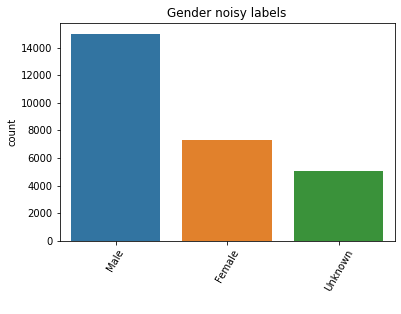

In [ ]:
sns.countplot(x = train_df["gender_label"], order = train_df["gender_label"].value_counts().index)
plt.xticks(rotation = 60)
plt.xlabel(" ")
plt.title('Gender noisy labels');

In [ ]:
#Labels for test data
gender_weak_labels_test = label_model_gender.predict(L=L_gender_test)
probs_test_gender = label_model_gender.predict_proba(L=L_gender_test)

In [ ]:
gender_test_df["predictions"] = gender_weak_labels_test
gender_test_df["predictions"] = gender_test_df["predictions"].map({1:"Male", 0:"Female", -1:"Unknown"})
gender_test_df["predictions"].value_counts()

## Age

### Majority Model

In [ ]:
majority_model_age = MajorityLabelVoter(cardinality = 5)
majority_predictions_age = majority_model_age.predict(L=L_age) #On train set
majority_model_age_test = MajorityLabelVoter(cardinality = 5)
majority_predictions_age_test = majority_model_age_test.predict(L=L_age_test)  #On test set
age_test_df["predictions_majority"] = majority_predictions_age_test
age_test_df["predictions_majority"] = age_test_df["predictions_majority"].map({4:"40+", 3:"30-39", 2:"20-29", 1: "-18", -1:"Unknown"})

### Label model

In [ ]:
label_model_age = LabelModel(cardinality=5, verbose=True)
label_model_age.fit(L_train=L_age, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 502.36epoch/s]
INFO:root:Finished Training


In [ ]:
age_weak_labels = label_model_age.predict(L=L_age)
probs_train_age = label_model_age.predict_proba(L=L_age)

In [ ]:
age_weak_labels_test = label_model_age.predict(L=L_age_test)
probs_test_age = label_model_age.predict_proba(L=L_age_test)

In [ ]:
age_test_df["predictions"] = age_weak_labels_test
age_test_df["predictions"] = age_test_df["predictions"].map({4:"40+", 3:"30-39", 2:"20-29", 1: "-18", -1:"Unknown"})
age_test_df["predictions"].value_counts()

In [ ]:
train_df["age_label"] = age_weak_labels
train_df["age_label"] = train_df["age_label"].map({4:"40+", 3:"30-39", 2:"20-29", 1: "-18", -1:"Unknown"})
train_df["age_label"].value_counts()

Unknown    26175
20-29        887
40+          191
30-39        107
-18           64
Name: age_label, dtype: int64

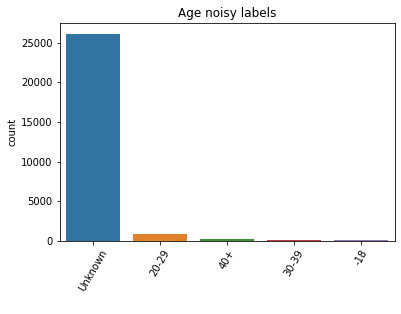

In [ ]:
sns.countplot(x = train_df["age_label"], order = train_df["age_label"].value_counts().index)
plt.xticks(rotation = 60)
plt.xlabel(" ")
plt.title('Age noisy labels');

## Location

### Majority model

In [ ]:
majority_model_location = MajorityLabelVoter(cardinality = 7)
majority_predictions_location = majority_model_location.predict(L=L_location) 
majority_model_location_test = MajorityLabelVoter(cardinality = 7)
majority_predictions_location_test = majority_model_location_test.predict(L=L_location_test) 
location_test_df["predictions_majority"] = majority_predictions_location_test
location_test_df["predictions_majority"] = location_test_df["predictions_majority"].map({0:"Antwerpen", 1:"Limburg", 2:"Oost_Vlaanderen",
                                                                                         3:"West_Vlaanderen", 4:"Vlaams_Brabant", 
                                                                                         5:"Brussel_Wallonie", 6: "Other", -1:"Unknown"})
location_test_df["predictions_majority"].value_counts()

### Label Model

In [ ]:
label_model_location = LabelModel(cardinality=7, verbose=True)
label_model_location.fit(L_train=L_location, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
 57%|█████▋    | 287/500 [00:00<00:00, 1046.81epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.000]
INFO:root:[400 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 1038.84epoch/s]
INFO:root:Finished Training


In [ ]:
location_weak_labels = label_model_location.predict(L=L_location)
probs_train_location = label_model_location.predict_proba(L=L_location)

In [ ]:
train_df["location_label"] = location_weak_labels
train_df["location_label"] = train_df["location_label"].map({0:"Antwerpen", 1:"Limburg", 2:"Oost_Vlaanderen", 3:"West_Vlaanderen", 
                                                           4:"Vlaams_Brabant", 5:"Brussel_Wallonie", 6: "Other", -1:"Unknown"})

Unknown             0.542262
Other               0.125292
Antwerpen           0.080149
Brussel_Wallonie    0.064834
West_Vlaanderen     0.061370
Oost_Vlaanderen     0.058416
Vlaams_Brabant      0.037340
Limburg             0.030338
Name: location_label, dtype: float64

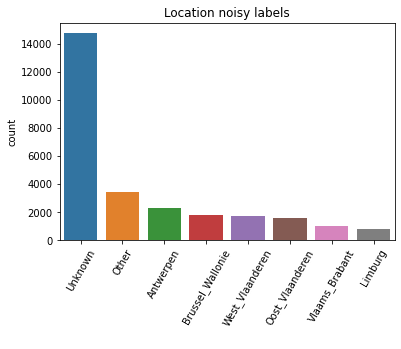

In [ ]:
sns.countplot(x = train_df["location_label"], order = train_df["location_label"].value_counts().index)
plt.xticks(rotation = 60)
plt.xlabel(" ")
plt.title('Location noisy labels');

In [ ]:
#Labels for test data
location_weak_labels_test = label_model_location.predict(L=L_location_test)
probs_test_location = label_model_location.predict_proba(L=L_location_test)

In [ ]:
location_test_df["predictions"] = location_weak_labels_test
location_test_df["predictions"] = location_test_df["predictions"].map({0:"Antwerpen", 1:"Limburg", 2:"Oost_Vlaanderen", 3:"West_Vlaanderen", 
                                                           4:"Vlaams_Brabant", 5:"Brussel_Wallonie", 6: "Other", -1:"Unknown"})
location_test_df["predictions"].value_counts()

# Evaluation of label models on test set

### Gender

In [ ]:
#Coverage of the gender LFs
print("Train set coverage : %s"%LFAnalysis(L=L_gender, lfs=lfs_gender).label_coverage())
print("Test set coverage : %s"%LFAnalysis(L=L_gender_test, lfs=lfs_gender).label_coverage())

Train set coverage : 0.8149431155192532
Test set coverage : 0.8752556237218814


In [ ]:
#Evaluating on the full test set (counting the unknowns as error)

print("Accuracy score majority model : %s"%accuracy_score(target_gender, gender_test_df["predictions_majority"]))
print("Macro F1 score majority model : %s"%f1_score(target_gender, gender_test_df["predictions_majority"], average = 'macro'))
print(pd.crosstab(target_gender, gender_test_df["predictions_majority"]))
print("Accuracy score label model : %s"%accuracy_score(target_gender, gender_test_df["predictions"]))
print("Macro F1 score label model : %s"%f1_score(target_gender, gender_test_df["predictions"], average = 'macro'))
print(pd.crosstab(target_gender, gender_test_df["predictions"]))

Accuracy score majority model : 0.8220858895705522
Macro F1 score majority model : 0.5821120689655173
predictions_majority   Female  Male  Unknown
gender_label_majority                       
Female                    108     9       35
Male                        1   294       42
Accuracy score label model : 0.8404907975460123
Macro F1 score label model : 0.5886792032192262
predictions            Female  Male  Unknown
gender_label_majority                       
Female                    120     6       26
Male                       11   291       35


## Age

In [ ]:
target_age = target_age.apply(lambda row : '20-29' if row == '19-29' else row)

In [ ]:
#Coverage of the gender LFs
print("Train set coverage : %s"%LFAnalysis(L=L_age, lfs=lfs_age).label_coverage())
print("Test set coverage : %s"%LFAnalysis(L=L_age_test, lfs=lfs_age).label_coverage())

Train set coverage : 0.045544049008168025
Test set coverage : 0.09116022099447514


In [ ]:
rank_mapping = {"40+":4, "30-39":3, "20-29":2, "-18":1}

In [ ]:
#Evaluating on the full test set (counting the unknowns as error)
#Same score for majority vote and generative (not surprising given the small coverage)
print("Accuracy score majority model : %s"%accuracy_score(target_age, age_test_df["predictions_majority"]))
print("Macro F1 score majority model : %s"%f1_score(target_age, age_test_df["predictions_majority"], average = 'macro'))
print(pd.crosstab(target_age, age_test_df["predictions_majority"]))
print("Accuracy score label model : %s"%accuracy_score(target_age, age_test_df["predictions"]))
print("Macro F1 score label model : %s"%f1_score(target_age, age_test_df["predictions"], average = 'macro'))
print(pd.crosstab(target_age, age_test_df["predictions"]))

Accuracy score majority model : 0.08011049723756906
Macro F1 score majority model : 0.161582177266246
predictions_majority  -18  20-29  30-39  40+  Unknown
age_label_majority                                   
-18                     1      0      0    0        3
20-29                   1     22      0    0       84
30-39                   0      0      4    0       59
40+                     0      2      1    2      183
Accuracy score label model : 0.08011049723756906
Macro F1 score label model : 0.161582177266246
predictions         -18  20-29  30-39  40+  Unknown
age_label_majority                                 
-18                   1      0      0    0        3
20-29                 1     22      0    0       84
30-39                 0      0      4    0       59
40+                   0      2      1    2      183


## Location


In [ ]:
target_location = target_location.apply(lambda row : 'Brussel_Wallonie' if row in ['Brussel','Wallonië']
                                        else 'Vlaams_Brabant' if row == 'Vlaams-Brabant'
                                        else 'Oost_Vlaanderen' if row == 'Oost-Vlaanderen'
                                        else 'West_Vlaanderen' if row == 'West-Vlaanderen'
                                        else 'Other' if row == 'Nederland'
                                        else row)

In [ ]:
#Coverage of the gender LFs
print("Train set coverage : %s"%LFAnalysis(L=L_location, lfs=lfs_location).label_coverage())
print("Test set coverage : %s"%LFAnalysis(L=L_location_test, lfs=lfs_location).label_coverage())

Train set coverage : 0.457737747957993
Test set coverage : 0.5278450363196125


In [ ]:
print("Accuracy score majority model : %s"%accuracy_score(target_location, location_test_df["predictions_majority"]))
print("Macro F1 score majority model : %s"%f1_score(target_location, location_test_df["predictions_majority"], average = 'macro'))
print(pd.crosstab(target_location,location_test_df["predictions_majority"]))
print("Accuracy score label model : %s"%accuracy_score(target_location, location_test_df["predictions"]))
print("Macro F1 score label model : %s"%f1_score(target_location, location_test_df["predictions"], average = 'macro'))
print(pd.crosstab(target_location, location_test_df["predictions"]))

Accuracy score majority model : 0.5036319612590799
Macro F1 score majority model : 0.609153805096392
predictions_majority     Antwerpen  Brussel_Wallonie  Limburg  \
location_label_majority                                         
Antwerpen                       34                 1        0   
Brussel_Wallonie                 0                22        1   
Limburg                          0                 0       13   
Oost_Vlaanderen                  0                 0        0   
Other                            0                 0        0   
Vlaams_Brabant                   0                 0        0   
West_Vlaanderen                  0                 0        0   

predictions_majority     Oost_Vlaanderen  Other  Unknown  Vlaams_Brabant  \
location_label_majority                                                    
Antwerpen                              1      0       38               0   
Brussel_Wallonie                       0      0       11               0   
Limburg  

# Output
Write predicted labels to csv file

In [ ]:
columns = ["user_id", "age_label", "gender_label", "location_label"]
train_df.to_csv('output/snorkel_labels.csv', 
               columns = columns,
               index = False)